In [7]:
import control as ct, numpy as np, matplotlib.pyplot as plt

# Funções de transferência do controlador PID discreto:
# $$G_c(z) = K_p + \frac{K_i}{1-z^{-1}} + K_d\cdot(1-z^-1)$$

# $$G_c(z) = K_C \cdot \frac{(z-z_{c1})\cdot(z-z_{c2})}{z\cdot(z-1)}$$

In [8]:
def create_servo(k, tau):
    return k*ct.tf(1, [1, 0])*ct.tf(1, [tau, 1])

In [9]:
def plot_response(sys, t, u, grid_major = 1, grid_minor = 0.2, display = True):
    response = ct.forced_response(ct.feedback(sys), t, u)
    if display:
        plt.grid()
        plt.plot(response.time, response.outputs)
        plt.show()
    return response

In [10]:
k = 735
tau = 0.055
T = 1e-3

servo = create_servo(k, tau)
servo

TransferFunction(array([735.]), array([0.055, 1.   , 0.   ]))

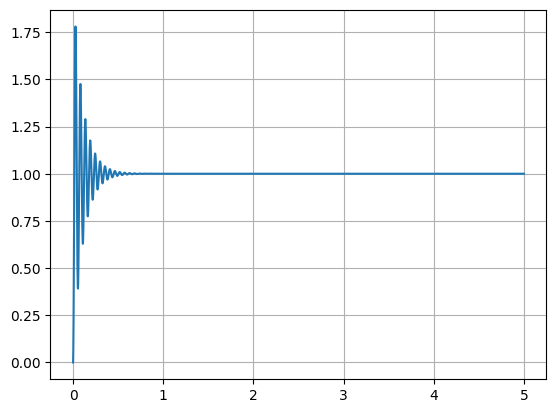

In [11]:
time = np.arange(0, 5, T)
step = np.ones(len(time))
resp = plot_response(servo, time, step)

In [12]:
def project_pid(sys, csi, ts, T, theta=-3):
    omega_n = 4/(ts*csi)
    omega_d = omega_n * np.sqrt(1-csi**2)
    dom_s = -csi*omega_n + 1j*omega_d
    dom_z = np.e**(T*dom_s)
    sigma = dom_z.real
    omega = dom_z.imag
    gz = ct.c2d(sys, T)
    zc1 = np.sort(gz.poles())[-2]
    tan = np.tan(np.deg2rad(theta))
    zc2 = (tan*(np.abs(dom_z)**2-sigma)+omega)/(omega+tan*(sigma-1))
    gc_num = np.convolve([1, -zc1], [1, -zc2])
    gc_den = np.convolve([1, 0], [1, -1])
    gc = ct.tf(gc_num, gc_den, T)
    series = gz*gc
    kc = 1/np.abs(series(dom_z))
    return gz, kc*gc

In [17]:
gz, gc = project_pid(servo, csi=0.8, ts=0.03, T=T)

/home/nikolas/.local/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


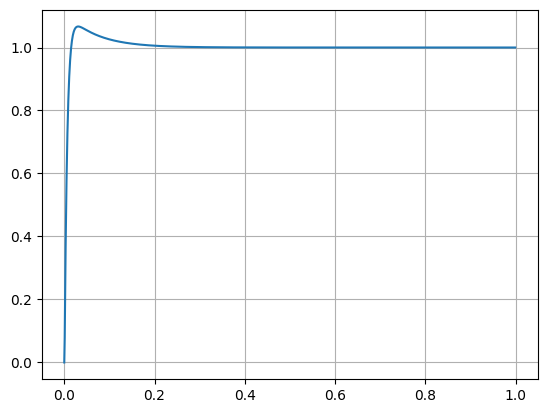

In [14]:
time = np.arange(0, 1, T)
step = np.ones(len(time))
resp = plot_response(gc*gz, time, step)

In [15]:
def compare_step(sys1, sys2, time):
    step = np.ones(len(time))
    resp1 = plot_response(sys1, time, step, display=False)
    resp2 = plot_response(sys2, time, step, display=False)
    plt.grid()
    plt.plot(resp1.time, resp1.outputs, c='r', label="Não compensado")
    plt.plot(resp2.time, resp2.outputs, c='b', label="Compensado")
    plt.legend()
    plt.show()

/home/nikolas/.local/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


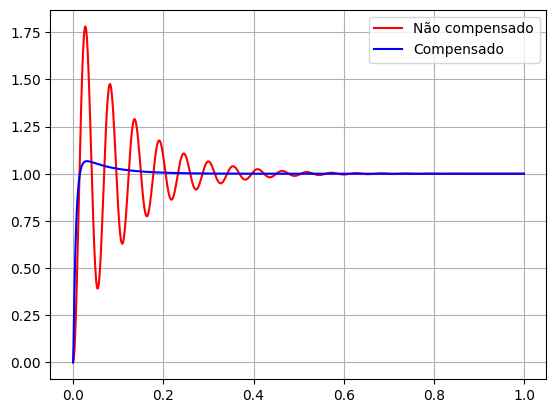

In [18]:
compare_step(servo, gc*gz, time)

In [90]:
def project_lead(sys, csi, ts):
    omega_n = 4/(ts*csi)
    omega_d = omega_n * np.sqrt(1-csi**2)
    dom_s = -csi*omega_n + 1j*omega_d
    zc = np.sort(sys.poles()[np.where(np.abs(sys.poles()) > 10e-5)])[0] # zero = polo mais próximo da origem sem ser 0

    current_angle = 0
    for p in sys.poles()[np.where(sys.poles() != zc)]: # itera por todos os polos exceto o que foi cancelado
        y_tri = np.abs(dom_s.imag - p.imag)
        x_tri = np.abs(dom_s.real - p.real)
        theta = np.arctan(y_tri/x_tri) + np.pi/2 if p.real > dom_s.real else np.arctan(y_tri/x_tri)
        current_angle += theta

    for z in sys.zeros():
        y_tri = np.abs(dom_s.imag - z.imag)
        x_tri = np.abs(dom_s.real - z.real)
        theta = np.arctan(y_tri/x_tri) + np.pi/2 if z.real > dom_s.real else np.arctan(y_tri/x_tri)
        current_angle -= theta
    
    pole_angle = np.pi - current_angle
    pc = np.abs(dom_s.real) - np.abs(dom_s.imag)/np.tan(pole_angle)
    gc = ct.tf([1, -zc], [1, pc])
    k = 1/np.abs((gc*sys)(dom_s))
    return sys, k*gc

In [99]:
g, gc = project_lead(servo, csi=0.8, ts=0.03)
gc

TransferFunction(array([ 1.55895692+0.j, 28.3446712 +0.j]), array([ 1.        , 58.33333333]))

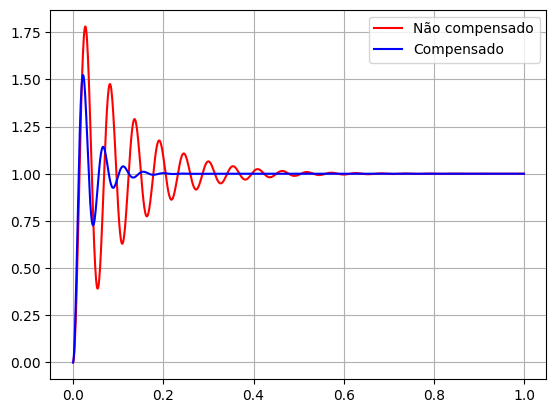

In [100]:
compare_step(servo, gc*servo, time)